In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

sns.set()
plt.rcParams["figure.figsize"] = (8,8)

# Part A

First find the FIM:
$$F_\theta = \frac{\partial \mu(\theta)}{\partial \theta}^T Q^{-1} \frac{\partial \mu(\theta)}{\partial \theta}$$

<br>

$$\frac{\partial \mu(\theta)}{\partial \theta} = \begin{bmatrix} 
    \frac{\partial}{\partial \theta} \big (1 - cos(\theta) \big ) \\
    \frac{\partial}{\partial \theta} \big (1 - cos(2\theta) \big ) \\
    \frac{\partial}{\partial \theta} \big (1 - cos(3\theta) \big ) \\
    \frac{\partial}{\partial \theta} \big (1 - cos(4\theta) \big ) \\
\end{bmatrix} = \begin{bmatrix} 
    sin(\theta) \\
    2 sin(2\theta) \\
    3 sin(3\theta) \\
    4 sin(4\theta) \\
\end{bmatrix}$$

<br>

\begin{align*}
F_\theta &= \frac{1}{\sigma^2}\big (sin(\theta) \big )^2 + \frac{1}{\sigma^2}\big (2 sin(2\theta) \big )^2 + \frac{1}{\sigma^2}\big (3 sin(3\theta) \big )^2 + \frac{1}{\sigma^2}\big (4 sin(4\theta) \big )^2 \\
         &= \frac{1}{\sigma^2} \Big (sin^2(\theta) + 4 sin^2(2\theta) + 9 sin^2(3\theta) + 16 sin^2(4\theta) \Big ) \\
         &= \frac{1}{\sigma^2} \sum\limits_{i=1}^{4} i^2 sin(i \theta)
\end{align*}


In [3]:
sigma_2 = 1  # Sigma squared
thetas = np.linspace(0, np.pi, 1000)  # Theta range from 0 to pi

def fisher(sigma_2, theta):
    return (1 / sigma_2) * ((np.sin(theta))**2 + (2 * np.sin(2 * theta))**2 + (3 * np.sin(3 * theta))**2 + (4 * np.sin(4 * theta))**2)


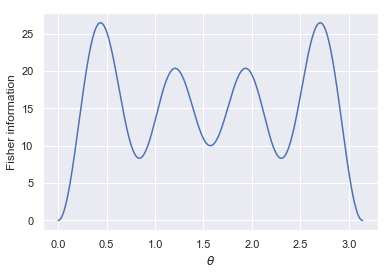

In [7]:
plt.plot(thetas, fisher(sigma_2, thetas))
plt.xlabel("$\\theta$")
plt.ylabel("Fisher information")
plt.show()